In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
print('measurement')
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print('')
print('station')
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.prcp.desc()).all()
results

[('2014-07-20', 11.53),
 ('2016-07-25', 9.64),
 ('2011-01-13', 8.81),
 ('2013-11-10', 8.06),
 ('2014-07-20', 7.97),
 ('2016-07-25', 7.65),
 ('2015-09-15', 6.83),
 ('2016-09-14', 6.7),
 ('2011-12-13', 6.42),
 ('2012-03-06', 6.38),
 ('2011-01-13', 6.3),
 ('2017-04-29', 6.25),
 ('2012-03-05', 6.24),
 ('2014-07-20', 5.98),
 ('2013-01-03', 5.96),
 ('2012-03-05', 5.71),
 ('2014-07-20', 5.54),
 ('2013-11-10', 5.54),
 ('2012-03-05', 5.37),
 ('2016-07-25', 5.35),
 ('2012-03-07', 5.32),
 ('2011-01-13', 5.21),
 ('2016-04-18', 5.09),
 ('2017-02-11', 5.04),
 ('2010-12-20', 5.04),
 ('2010-12-20', 4.95),
 ('2010-12-20', 4.94),
 ('2011-02-20', 4.88),
 ('2015-08-24', 4.81),
 ('2013-11-10', 4.76),
 ('2012-03-03', 4.68),
 ('2012-03-09', 4.6),
 ('2010-11-06', 4.56),
 ('2011-10-24', 4.47),
 ('2011-06-04', 4.43),
 ('2013-08-10', 4.32),
 ('2014-07-20', 4.3),
 ('2016-07-25', 4.2),
 ('2015-09-28', 4.18),
 ('2013-05-30', 4.07),
 ('2014-12-23', 4.03),
 ('2011-06-05', 4.02),
 ('2010-10-19', 4.01),
 ('2012-03-06',

In [30]:
# Calculate the date 1 year ago from the last data point in the database
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
year_ago = year_ago.strftime('%Y-%m-%d')
year_ago

'2016-08-23'

In [31]:
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

In [32]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_scores_df = pd.DataFrame(precipitation_scores, columns=['date', 'precipitation'])
precipitation_scores_df.set_index('date', inplace=True)
precipitation_scores_df = precipitation_scores_df.dropna()
precipitation_scores_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


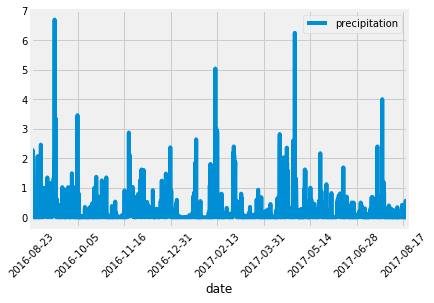

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp = precipitation_scores_df.plot().get_figure()
plt.xticks(rotation=45)
plt.show()
prcp.savefig("Images/Last_12_Months_Percipitation.png")

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station)
stations.count()

9

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
print(f' The most active station is {active_stations[0][0]}')

 The most active station is USC00519281


In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_stations[0][0]).all()

temp

print(f' Low: {temp[0][0]}, High: {temp[0][1]}, Avg: {temp[0][2]}')

 Low: 54.0, High: 85.0, Avg: 71.66378066378067


In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).filter(Measurement.date >= year_ago).\
    group_by(Measurement.date).all()

temp

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [40]:
temprature = pd.DataFrame(temp, columns=['date', 'observations'])
temprature.set_index('date', drop=True)
temprature.head()

,date,observations
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


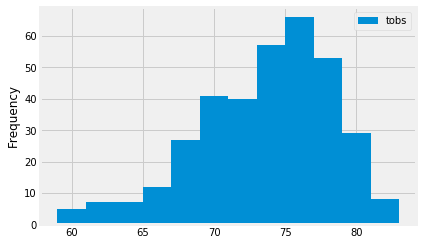

In [41]:
plt.hist(temprature['observations'],12, label="tobs")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/Last_12_Months_Temperature.png")
plt.show()

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[('2012-02-29', 62.0, 69.57142857142857, 74.0)]


In [43]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = dt.date(2018, 4, 1)
end = dt.date(2018, 4, 15)
previous_year = dt.timedelta(days=365)

trip = calc_temps((start-previous_year), (end-previous_year))
trip

[('2017-04-11', 67.0, 74.47368421052632, 82.0)]

In [44]:
# trip_df = pd.DataFrame(trip, columns=["date","tmin", "tavg", "tmax"])
# trip_df = trip_df.set_index('date', drop=True)
# trip_df.head()

trip_df = pd.DataFrame(trip, columns=['date', 'tmin', 'tavg', 'tmax'])
trip_df.set_index('date', drop=True)
trip_df.head()

,date,tmin,tavg,tmax
0,2017-04-11,67.0,74.473684,82.0


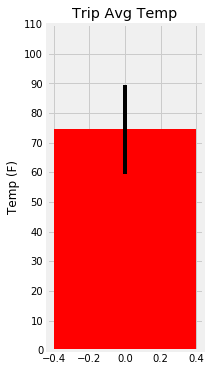

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = trip_df['tmax'] - trip_df['tmin']
plt.figure(figsize=[2.5, 6])
avg = plt.bar(trip_df.index.values, trip_df['tavg'], yerr=yerr, color="red")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.yticks(np.arange(0, 120, 10))
plt.savefig("Images/Trip_Avg_Temp.png")
plt.show()

In [46]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

last_year_start = start - previous_year
last_year_end = end - previous_year

rainfall_station = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.latitude,
                  Station.longitude,
                  Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= last_year_start)\
.filter(Measurement.date <= last_year_end)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_station

[('USC00516128',
  5.75,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  4.14,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 1.64, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  0.8999999999999999,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  0.36,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.27, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment 
Didn't do this part...don't hate me